In [91]:
import os, glob
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from datetime import datetime

from scipy import stats
from scipy.stats import norm

from statsmodels.formula.api import ols
import statsmodels.api as sm


In [2]:
from utils import (calc_performance, calc_performance_target, calc_performance_group, calc_performance_target_group, 
                   fit_ols_get_beta, run_bootstrapping, grouper, summarize_img_hit_by_duration, stack_data_for_bootstrapping)

In [3]:
paper_data_dir = '../data/'

# 0. Data cleaning

The main data file for Study 2 is RecMem_RSVP_data.csv. Below is an explanation for each of the column:

ID_REDACT:	Participant's Prolific ID (Partially redacted for privacy)

Condition:	Condition of the curren trial (Distintiveness level, Reconstruction error [RE] level and Duration [2: 34 ms, 5: 85 ms, 10: 167 ms])

target_img_1:	The first image shown in the RSVP sequence ('_F': denotes that this is a filler image; '_T' denotes that this is a target image)

target_img_2:	The second image shown in the RSVP sequence('_F': denotes that this is a filler image; '_T' denotes that this is a target image)

target_img_3:	The third image shown in the RSVP sequence ('_F': denotes that this is a filler image; '_T' denotes that this is a target image)

target_img_4:	The fourth image shown in the RSVP sequence ('_F': denotes that this is a filler image; '_T' denotes that this is a target image)

target_img_5:	The fifth image shown in the RSVP sequence ('_F': denotes that this is a filler image; '_T' denotes that this is a target image)

target_img_6:	The sixth image shown in the RSVP sequence ('_F': denotes that this is a filler image; '_T' denotes that this is a target image)

test_img:	The test image shown ('_F': denotes that this is a filler image; '_T' denotes that this is a target image)

response:	Participant's reponse (YES: participant thinks the target was present; NO: participant thinks the target was not present)

TrialType:	Trial type (correct response, YES: the target was present; NO: the target was not present)

timestamp: the time when the participant's response was recorded

In [4]:
subs_responses = pd.read_csv(os.path.join(paper_data_dir, 'RecMem_RSVP_data.csv'))

In [5]:
# First only include participants who meet the criteria specified in the pre-registration
trial_counts_per_block = subs_responses.groupby(['ID_REDACT','Condition'])['response'].count().reset_index().rename(columns={'response':'count'})

# Missing blocks
sub_block_count_all = trial_counts_per_block.groupby('ID_REDACT').count().reset_index()
missing_blocks = sub_block_count_all[sub_block_count_all['count']<12]['ID_REDACT'].unique()
print('# of participants excluded because they completed fewer than 12 blocks: {}'.format(len(missing_blocks)))

# Only keep the blocks with over 90% response rate
sub_block_count_all = trial_counts_per_block[trial_counts_per_block['count']>=32*0.9].groupby('ID_REDACT').count().reset_index()
not_enough_trials = trial_counts_per_block[(~trial_counts_per_block['ID_REDACT'].isin(missing_blocks))&
                                           (trial_counts_per_block['count']<32*0.9)]['ID_REDACT'].unique()
print('# of participants excluded because they did not give a response on over 10% of the trials on any given block despite having all 12 blocks: {}'.format(len(not_enough_trials)))


# of participants excluded because they completed fewer than 12 blocks: 19
# of participants excluded because they did not give a response on over 10% of the trials on any given block despite having all 12 blocks: 1


In [6]:
_subs_responses_filtered = subs_responses[(~subs_responses['ID_REDACT'].isin(missing_blocks))&
                                         (~subs_responses['ID_REDACT'].isin(not_enough_trials))]
print('We have {} participants after excluding those with incomplete data.'.format(len(_subs_responses_filtered['ID_REDACT'].unique())))
print('This is one more than we needed (N=45 in the pre-registration) so we will exclude the participant who came in last.')
timestamp = _subs_responses_filtered.drop_duplicates(subset=['ID_REDACT'], keep='first').sort_values(by=['timestamp'])
subs_to_lookat = timestamp['ID_REDACT'].values[:-1]
subs_to_lookat.sort()

We have 46 participants after excluding those with incomplete data.
This is one more than we needed (N=45 in the pre-registration) so we will exclude the participant who came in last.


In [7]:
performance_summary_all = calc_performance_group(subs_responses, subs_to_lookat)
# Make sure that all the participants have above-chance performance overall (dprime > 0)
assert np.all(performance_summary_all[performance_summary_all['duration']=='all']['dprime']>0)

/Users/qilin/PycharmProjects/SparseEncoding/forRelease/analysis_scripts/utils.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_sub_df['img_duration'] = [int(k[-1]) for k in curr_sub_df['Condition'].str.split('_')]


# 1 Graph RSVP results

In [8]:
performance_summary_targets = calc_performance_target_group(subs_responses, subs_to_lookat)


Text(0.5, 0, 'Duration (ms)')

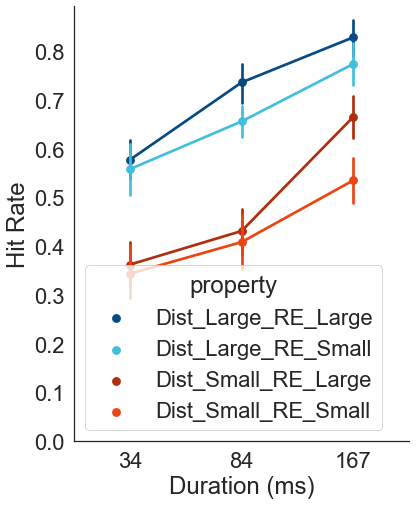

In [9]:
sns.set(font_scale=2)
sns.set_style('white')
plt.figure(figsize=(6,8))
curr_ax = sns.pointplot(x='duration', y ='hit', hue='property', 
          palette=['#084B83', '#42BFDD', '#B02E0C', '#EB4511'],
           hue_order=['Dist_Large_RE_Large','Dist_Large_RE_Small',
                    'Dist_Small_RE_Large','Dist_Small_RE_Small'],data=performance_summary_targets)
sns.despine(top=True, right=True)
_, ymax = curr_ax.get_ylim()
curr_ax.set_ylabel('Hit Rate')
curr_ax.set_ylim([0, ymax])
curr_ax.set_xticklabels(['34', '84', '167'])
curr_ax.set_xlabel('Duration (ms)')

Now generate the data file for running ANOVA in R. 

In [10]:
performance_summary_targets.to_csv(os.path.join(paper_data_dir,'Summary_targets.csv'))

Run bootstrapping analyses to directly compare the slope for large RE vs. small RE. 

In [11]:
large_dist_early = performance_summary_targets[(performance_summary_targets['Dist']=='Large')&
                                          (performance_summary_targets['duration']!=10)]
large_dist_early_results = run_bootstrapping(large_dist_early, subs_to_lookat)
tmp_df = pd.DataFrame(large_dist_early_results, columns=['Beta_diff'])
tmp_df['Dist'] = 'Large'
tmp_df['Stage'] = 'Early'
all_bootstrap_results = tmp_df

small_dist_early = performance_summary_targets[(performance_summary_targets['Dist']=='Small')&
                                          (performance_summary_targets['duration']!=10)]
small_dist_early_results = run_bootstrapping(small_dist_early, subs_to_lookat)
tmp_df = pd.DataFrame(small_dist_early_results, columns=['Beta_diff'])
tmp_df['Dist'] = 'Small'
tmp_df['Stage'] = 'Early'
all_bootstrap_results = all_bootstrap_results.append(tmp_df)

large_dist_late = performance_summary_targets[(performance_summary_targets['Dist']=='Large')&
                                          (performance_summary_targets['duration']!=2)]
large_dist_late_results = run_bootstrapping(large_dist_late, subs_to_lookat)
tmp_df = pd.DataFrame(large_dist_late_results, columns=['Beta_diff'])
tmp_df['Dist'] = 'Large'
tmp_df['Stage'] = 'Late'
all_bootstrap_results = all_bootstrap_results.append(tmp_df)

small_dist_late = performance_summary_targets[(performance_summary_targets['Dist']=='Small')&
                                          (performance_summary_targets['duration']!=2)]
small_dist_late_results = run_bootstrapping(small_dist_late, subs_to_lookat)
tmp_df = pd.DataFrame(small_dist_late_results, columns=['Beta_diff'])
tmp_df['Dist'] = 'Small'
tmp_df['Stage'] = 'Late'
all_bootstrap_results = all_bootstrap_results.append(tmp_df)

/Users/qilin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<matplotlib.collections.PathCollection object at 0x1a271afd68> 1000
<matplotlib.collections.PathCollection object at 0x1a2a268198> 1000
<matplotlib.collections.PathCollection object at 0x1a2a268160> 1000
<matplotlib.collections.PathCollection object at 0x1a2a268668> 1000


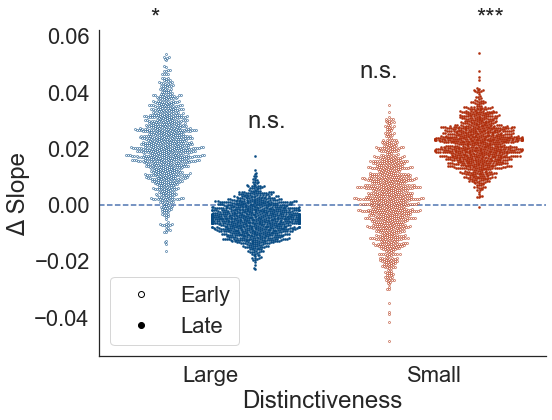

In [92]:
all_bootstrap_results[(all_bootstrap_results['Dist']=='Large')&
                     (all_bootstrap_results['Stage']=='Early')]['Beta_diff'].mean()

np.sum(all_bootstrap_results[(all_bootstrap_results['Dist']=='Large')&
                     (all_bootstrap_results['Stage']=='Early')]['Beta_diff']<0)

all_bootstrap_results[(all_bootstrap_results['Dist']=='Small')&
                     (all_bootstrap_results['Stage']=='Late')]['Beta_diff'].mean()

np.sum(all_bootstrap_results[(all_bootstrap_results['Dist']=='Small')&
                     (all_bootstrap_results['Stage']=='Late')]['Beta_diff']<0)

plt.figure(figsize=(8,6))
curr_ax = sns.swarmplot(x='Dist',order=['Large','Small'], hue = 'Stage', hue_order=['Early', 'Late'],
                        y='Beta_diff', dodge=True,size=2,
                        data=all_bootstrap_results)

curr_ax.axhline(0, ls='--')
curr_ax.set_ylabel('\u0394 Slope')
curr_ax.set_xlabel('Distinctiveness')


stage_list = ['Early', 'Late']
xtick_labels = curr_ax.get_xticklabels()
  
for curr_xtick_ind, curr_xtick_label in enumerate(xtick_labels):

    for curr_stage_ind, curr_stage in enumerate(stage_list):
        curr_beta_diff = all_bootstrap_results[(all_bootstrap_results['Dist']==curr_xtick_label.get_text())&
                                       (all_bootstrap_results['Stage']==curr_stage)]['Beta_diff'].values

        curr_pval = np.sum(curr_beta_diff<0)/1000

        if curr_pval > 0.1:
            sign_label = 'n.s.'
        elif (curr_pval <= 0.1) and (curr_pval > 0.05):
            sign_label = '~'
        elif (curr_pval <= 0.05) and (curr_pval > 0.01):
            sign_label = '*'
        elif (curr_pval <= 0.01) and (curr_pval > 0.001):
            sign_label = '**'
        elif (curr_pval <= 0.001) :
            sign_label = '***'
        curr_x_pos = curr_xtick_ind+((curr_stage_ind-0.5)/0.5)*0.25

        curr_y_pos = np.max(curr_beta_diff)+0.01

        #curr_ax.text(curr_x_pos, curr_y_pos, 'mean = {}, \np={}'.format(np.mean(curr_beta_diff).round(2),curr_pval), horizontalalignment='center')
        curr_ax.text(curr_x_pos, curr_y_pos, '{}'.format(sign_label), horizontalalignment='center')
        
swarm_cols = curr_ax.collections

curr_df = all_bootstrap_results
N_cats = len(np.unique(curr_df.Dist))
N_hues = len(np.unique(curr_df.Stage))


face_colors = ['#ffffff',"#084B83","#ffffff",'#B02E0C'] 
edge_colors = ["#084B83","#084B83","#B02E0C","#B02E0C"] 

counter = 0
for swarms in grouper(swarm_cols, N_hues):
    for swarm in swarms:
        if counter <4:
            print(swarm, len(swarm.get_offsets()))
            #swarm.set_paths([marker])
            swarm.set_facecolors(face_colors[counter])
            swarm.set_linewidths([0.5])
            swarm.set_edgecolors(edge_colors[counter])
            counter += 1
            

sns.despine(top=True, right=True)

# Make legends
legend_elements = [Line2D([0], [0], color='w',marker='o',markerfacecolor='None', markeredgecolor='black',
                         label='Early'),
                   Line2D([0], [0], color='w',marker='o',markerfacecolor='black', markeredgecolor='black',
                         label='Late')

                   
]
curr_ax.legend(handles = legend_elements)


In [13]:
print('Beta difference during early stage for images with large distinctiveness:{}'.format(
    np.round(all_bootstrap_results[(all_bootstrap_results['Dist']=='Large')&
                     (all_bootstrap_results['Stage']=='Early')]['Beta_diff'].mean(),3)))
print('p value:{}'.format(
    np.round(np.sum(all_bootstrap_results[(all_bootstrap_results['Dist']=='Large')&
                     (all_bootstrap_results['Stage']=='Early')]['Beta_diff']<0)/1000,3)))

Beta difference during early stage for images with large distinctiveness:0.02
p value:0.045


In [14]:
print('Beta difference during late stage for images with large distinctiveness:{}'.format(
    np.round(all_bootstrap_results[(all_bootstrap_results['Dist']=='Large')&
                     (all_bootstrap_results['Stage']=='Late')]['Beta_diff'].mean(),3)))
print('p value:{}'.format(
    np.round(np.sum(all_bootstrap_results[(all_bootstrap_results['Dist']=='Large')&
                     (all_bootstrap_results['Stage']=='Late')]['Beta_diff']<0)/1000,3)))

Beta difference during late stage for images with large distinctiveness:-0.005
p value:0.813


In [15]:
print('Beta difference during early stage for images with small distinctiveness:{}'.format(
    np.round(all_bootstrap_results[(all_bootstrap_results['Dist']=='Small')&
                     (all_bootstrap_results['Stage']=='Early')]['Beta_diff'].mean(),3)))
print('p value:{}'.format(
    np.round(np.sum(all_bootstrap_results[(all_bootstrap_results['Dist']=='Small')&
                     (all_bootstrap_results['Stage']=='Early')]['Beta_diff']<0)/1000,3)))

Beta difference during early stage for images with small distinctiveness:0.001
p value:0.449


In [16]:
print('Beta difference during late stage for images with small distinctiveness:{}'.format(
    np.round(all_bootstrap_results[(all_bootstrap_results['Dist']=='Small')&
                     (all_bootstrap_results['Stage']=='Late')]['Beta_diff'].mean(),3)))
print('p value:{}'.format(
    np.round(np.sum(all_bootstrap_results[(all_bootstrap_results['Dist']=='Small')&
                     (all_bootstrap_results['Stage']=='Late')]['Beta_diff']<0)/1000,3)))

Beta difference during late stage for images with small distinctiveness:0.022
p value:0.001


# 3 Model explanation by time 

In [35]:
layer_5_data = pd.read_csv(os.path.join(paper_data_dir, 'Isola_layer_5_dist_rec.csv'))
layer_7_data = pd.read_csv(os.path.join(paper_data_dir, 'Isola_layer_7_dist_rec.csv'))

In [36]:
combine_measure = layer_7_data[['Image index', 'Reconstruction error']].merge(layer_5_data[['Image index', 'Distinctiveness']])

In [37]:
# Keep only the target trials
targets_only = subs_responses[(subs_responses['ID_REDACT'].isin(subs_to_lookat))&
                              (subs_responses['TrialType']=='YES')].reset_index(drop=True)
grading_dict = {'YES':1,
               'NO':0}
targets_only['response_num'] = targets_only['response'].map(grading_dict)
subs_df = targets_only['ID_REDACT'].drop_duplicates().reset_index()
assert len(subs_df==45)

In [38]:
duration_list = [2, 5, 10]
img_hit_by_duration = summarize_img_hit_by_duration(targets_only, duration_list)

In [39]:
# Bootstrap participants to get a distribution
corr_df_sampled = pd.DataFrame(columns=['duration', 'measure', 'r', 'iter'])
for curr_iter in tqdm(range(1000)):
    sampled_subjects = subs_df.sample(frac=1, replace=True, random_state=curr_iter)
    sampled_data = stack_data_for_bootstrapping(sampled_subjects['ID_REDACT'].values, targets_only)
    
    sampled_img_summary = summarize_img_hit_by_duration(sampled_data, duration_list)
    sampled_img_summary = sampled_img_summary.merge(combine_measure)
    
    for curr_duration in duration_list:
        curr_df = sampled_img_summary[sampled_img_summary['duration']==curr_duration]
        r_dist, _ = stats.pearsonr(curr_df['hit'], curr_df['Distinctiveness'])
        r_RE, _ = stats.pearsonr(curr_df['hit'], curr_df['Reconstruction error'])

        corr_df_sampled.loc[len(corr_df_sampled)] = {'duration':curr_duration, 
                                     'measure':'Dist.', 
                                     'r':r_dist,
                                    'iter': curr_iter}

        corr_df_sampled.loc[len(corr_df_sampled)] = {'duration':curr_duration, 
                                     'measure':'RE', 
                                     'r':r_RE,
                                    'iter': curr_iter}
    

In [40]:
# Run statistical test
dist_betas = []
RE_betas = []
diff_betas = []
for curr_iter in tqdm(range(1000)):
    
    curr_dist_df = corr_df_sampled[(corr_df_sampled['measure']=='Dist.')&
                                  (corr_df_sampled['iter']==curr_iter)]
    x = stats.zscore(pd.to_numeric(curr_dist_df['duration']))
    y = stats.zscore(curr_dist_df['r'])
    # Fit a model to predict 
    dist_model = sm.OLS(y, sm.add_constant(x)).fit()
    beta_dist = dist_model.params[1]
    
    curr_RE_df = corr_df_sampled[(corr_df_sampled['measure']=='RE')&
                                  (corr_df_sampled['iter']==curr_iter)]
    x =  stats.zscore(pd.to_numeric(curr_RE_df['duration']))
    y = stats.zscore(curr_RE_df['r'])
    RE_model = sm.OLS(y, sm.add_constant(x)).fit()
    beta_RE = RE_model.params[1]
    
    dist_betas.append(beta_dist)
    RE_betas.append(beta_RE)
    
    diff_betas.append(beta_RE-beta_dist)

In [41]:
print('p value for the slope of distinctiveness: {}'.format(np.sum(np.array(dist_betas)<0)/1000))

p value for the slope of distinctiveness: 0.526


In [42]:
print('p value for the slope of reconstruction error: {}'.format(np.sum(np.array(RE_betas)<0)/1000))

p value for the slope of reconstruction error: 0.0


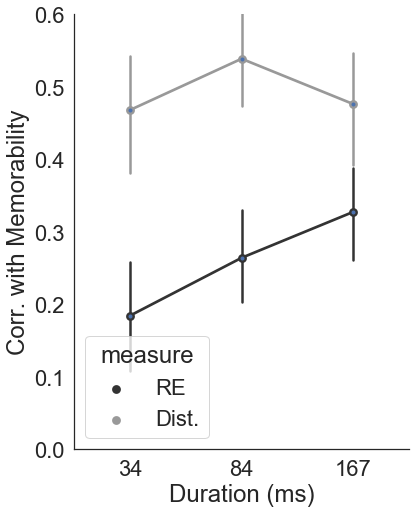

In [43]:
sns.set(font_scale=2)
sns.set_style('white')
plt.figure(figsize=(6,8))
curr_ax = sns.pointplot(x='duration', y = 'r', hue='measure', ci=None, hue_order=['RE', 'Dist.'], 
                        palette = ['#333333','#999999'],
              data=corr_df_sampled)
# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in curr_ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

pairs_order = [('RE',2), ('RE',5), ('RE', 10), ('Dist.',2), ('Dist.',5), ('Dist.', 10)]
errorbars_list = []
for curr_ind, curr_pair in enumerate(pairs_order):
    curr_rs = corr_df_sampled[(corr_df_sampled['measure']==curr_pair[0])&
                             (corr_df_sampled['duration']==curr_pair[1])]['r'].values
    curr_rs.sort()
    errorbars_list.append((y_coords[curr_ind]-curr_rs[25], curr_rs[-25]-y_coords[curr_ind]))

plotline, caps, barlinecols =curr_ax.errorbar(x_coords, y_coords, 
                 yerr=np.array(errorbars_list).T,
                 fmt='.', lw=2.5,
                ecolor=['#333333']*3+['#999999']*3)

plt.setp(barlinecols[0], capstyle="round")


curr_ax.set_ylim(0,0.6)
curr_ax.set_xlim(-0.5, 2.5)
curr_ax.set_xticklabels(['34', '84', '167'])
curr_ax.set_xlabel('Duration (ms)')
curr_ax.set_ylabel('Corr. with Memorability')

sns.despine(top=True, right=True)